In [1]:
%cd ../..

/home/dmoreno/ATAT_ZTF/elasticc_one


# Confusion matrices

In [2]:
import os
import json 
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#from utils import get_y_test_pred_folds, get_confusion_matrix

/home/dmoreno/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
path_data = './data/final/ZTF_ff/LC_MD_FEAT_v3_fixed_windows_200'
path_results = './results/ZTF/LC_MD_FEAT/lc_md_feat_mta_v3_fixed_windows/MTA'
time_to_eval = 2048

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [5]:
objects_partitions = pd.read_parquet('./data/partitions/v3/partitions.parquet')
obj_label = objects_partitions[objects_partitions['partition'] == 'test']
y_real_test = obj_label['alerceclass'].values
obj_label = ['aid_{}'.format(x) for x in obj_label['oid'].values]
obj_label

['aid_ZTF18adldhip',
 'aid_ZTF19aasbgeb',
 'aid_ZTF18aayfbqd',
 'aid_ZTF19ablyzbl',
 'aid_ZTF18actabfv',
 'aid_ZTF18aaztkvq',
 'aid_ZTF21aaphzsw',
 'aid_ZTF19aarhrcv',
 'aid_ZTF17aaajmxw',
 'aid_ZTF18acrvact',
 'aid_ZTF22aaahdyl',
 'aid_ZTF18aacebav',
 'aid_ZTF19abnqhwd',
 'aid_ZTF19abjgdow',
 'aid_ZTF18abklljv',
 'aid_ZTF18aalaphh',
 'aid_ZTF23aaaziou',
 'aid_ZTF17aacihzd',
 'aid_ZTF22abnmzar',
 'aid_ZTF17aaaoite',
 'aid_ZTF18abcurfb',
 'aid_ZTF18adbbyzu',
 'aid_ZTF18aaxpqts',
 'aid_ZTF18aacgwxk',
 'aid_ZTF18admcecv',
 'aid_ZTF18abukrnx',
 'aid_ZTF19aapuibt',
 'aid_ZTF18aawccep',
 'aid_ZTF21aahfpup',
 'aid_ZTF19aaoztzf',
 'aid_ZTF18aayijfg',
 'aid_ZTF18abgpcbj',
 'aid_ZTF18abwbiev',
 'aid_ZTF18actawil',
 'aid_ZTF20abyzomt',
 'aid_ZTF17aabxqbf',
 'aid_ZTF18abukymf',
 'aid_ZTF18abvbsoc',
 'aid_ZTF18actunfi',
 'aid_ZTF18aazfeau',
 'aid_ZTF22aaayewi',
 'aid_ZTF18aaxtcdl',
 'aid_ZTF18abtoxjw',
 'aid_ZTF18acdpxfb',
 'aid_ZTF18aabvmax',
 'aid_ZTF18abbogne',
 'aid_ZTF18aapnlus',
 'aid_ZTF18ab

In [6]:
y_real_test

array(['AGN', 'QSO', 'EA', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

In [7]:
len(obj_label)

8346

In [8]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{0: 'AGN', 8: 'Blazar', 12: 'CEP', 5: 'CV/Nova', 15: 'DSCT', 2: 'EA', 10: 'EB/EW', 11: 'LPV', 21: 'Microlensing', 14: 'Periodic-Other', 1: 'QSO', 13: 'RRLab', 6: 'RRLc', 7: 'RSCVn', 17: 'SLSN', 9: 'SNII', 19: 'SNIIb', 20: 'SNIIn', 4: 'SNIa', 16: 'SNIbc', 18: 'TDE', 3: 'YSO'}


In [9]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['AGN', 'QSO', 'EA', 'YSO', 'SNIa', 'CV/Nova', 'RRLc', 'RSCVn', 'Blazar', 'SNII', 'EB/EW', 'LPV', 'CEP', 'RRLab', 'Periodic-Other', 'DSCT', 'SNIbc', 'SLSN', 'TDE', 'SNIIb', 'SNIIn', 'Microlensing']


In [10]:
predictions = torch.load('{}/all_predictions_times.pt'.format(path_results))
predictions

{'SNID': array([b'ZTF17aaaecgi_0', b'ZTF17aaaecgi_1', b'ZTF17aaaecgi_2', ...,
        b'ZTF23abcvqkd_3', b'ZTF23abcvqkd_4', b'ZTF23abcvqkd_5'],
       dtype=object),
 'y_test': tensor([10, 10, 10,  ...,  4,  4,  4]),
 'list_y_pred': {'test_16': array([ 2,  2,  2, ..., 16, 16, 16]),
  'test_32': array([10, 10, 10, ..., 16, 16, 16]),
  'test_64': array([10, 10, 10, ..., 16, 16,  4]),
  'test_128': array([10, 10, 10, ..., 16, 16,  4]),
  'test_256': array([10, 10, 10, ..., 16, 16,  4]),
  'test_512': array([10, 10, 10, ..., 16, 16,  4]),
  'test_1024': array([10, 10, 10, ..., 16, 16,  4]),
  'test_2048': array([10, 10, 10, ...,  4,  4,  4])},
 'list_y_pred_prob': {'test_16': array([[3.6222719e-08, 2.7924095e-08, 9.7187668e-01, ..., 1.8353014e-14,
          2.1992568e-09, 3.1646664e-12],
         [1.1936895e-07, 6.4801313e-08, 9.0987587e-01, ..., 6.7129408e-14,
          4.0006555e-08, 8.9388375e-12],
         [8.8252079e-08, 4.6659107e-08, 9.0283567e-01, ..., 9.3514367e-13,
          2.80

In [11]:
#######################################################

In [12]:
predictions['SNID']

array([b'ZTF17aaaecgi_0', b'ZTF17aaaecgi_1', b'ZTF17aaaecgi_2', ...,
       b'ZTF23abcvqkd_3', b'ZTF23abcvqkd_4', b'ZTF23abcvqkd_5'],
      dtype=object)

In [13]:
predictions['list_y_pred_prob']['test_2048'].shape

(252810, 22)

In [14]:
import pandas as pd
import numpy as np

# Simulando el array original dado
array_original = predictions['SNID']

# Convertir cada elemento del array a una tupla (identificador, número)
tuplas = [tuple(x.decode('utf-8').rsplit('_', 1)) for x in array_original]

# Convertir las partes numéricas a enteros
tuplas = [(x[0], int(x[1])) for x in tuplas]

# Crear el MultiIndex
multi_index = pd.MultiIndex.from_tuples(tuplas, names=['oid', 'window_id'])

multi_index

MultiIndex([('ZTF17aaaecgi', 0),
            ('ZTF17aaaecgi', 1),
            ('ZTF17aaaecgi', 2),
            ('ZTF17aaaecgi', 3),
            ('ZTF17aaaecgi', 4),
            ('ZTF17aaaecgi', 5),
            ('ZTF17aaaecgi', 6),
            ('ZTF17aaaecgi', 7),
            ('ZTF17aaaedvi', 0),
            ('ZTF17aaaedvi', 1),
            ...
            ('ZTF23aavxvsz', 1),
            ('ZTF23aavxvsz', 2),
            ('ZTF23aavxvsz', 3),
            ('ZTF23aavxvsz', 4),
            ('ZTF23abcvqkd', 0),
            ('ZTF23abcvqkd', 1),
            ('ZTF23abcvqkd', 2),
            ('ZTF23abcvqkd', 3),
            ('ZTF23abcvqkd', 4),
            ('ZTF23abcvqkd', 5)],
           names=['oid', 'window_id'], length=252810)

In [15]:
df_probabilidades = pd.DataFrame(predictions['list_y_pred_prob']['test_2048'], index=multi_index, columns=sort_classes)

# Agrupar por 'oid' y calcular el promedio de las probabilidades para cada grupo
df_promedio = df_probabilidades.groupby(level='oid').mean()

df_promedio.head()  

AGN           QSO            EA           YSO   
oid                                                                    
ZTF17aaaaabj  5.725557e-09  1.189550e-09  1.568945e-06  6.628213e-09  \
ZTF17aaaaaej  3.060561e-09  1.683131e-09  2.493824e-04  1.087981e-07   
ZTF17aaaaafz  7.258170e-08  5.029711e-08  6.862045e-07  9.992234e-01   
ZTF17aaaaajg  4.622291e-07  1.690477e-07  1.347649e-03  1.822732e-07   
ZTF17aaaaavq  1.426139e-09  7.004443e-09  1.621647e-08  2.834639e-05   

                      SNIa       CV/Nova          RRLc         RSCVn   
oid                                                                    
ZTF17aaaaabj  4.790098e-10  4.290173e-07  9.609953e-01  2.116889e-03  \
ZTF17aaaaaej  1.012873e-09  2.093691e-06  8.744407e-01  7.240136e-03   
ZTF17aaaaafz  2.639411e-11  8.003891e-05  6.940259e-07  5.103305e-07   
ZTF17aaaaajg  4.569930e-09  6.971712e-06  9.662008e-01  3.380524e-03   
ZTF17aaaaavq  1.759599e-08  1.778992e-05  1.330761e-08  6.090410e-06   

                    Blazar          SNII  ...           CEP         RRLab   
oid                                       ...                               
ZTF17aaaaabj  3.583343e-10  8.331371e-10  ...  3.573284e-02  5.908103e-04  \
ZTF17aaaaaej  7.757199e-10  5.067580e-11  ...  5.501013e-03  9.318088e-05   
ZTF17aaaaafz  1.268743e-05  2.218368e-11  ...  2.124778e-06  2.958371e-07   
ZTF17aaaaajg  2.068493e-08  1.210635e-09  ...  7.115405e-05  2.948249e-05   
ZTF17aaaaavq  1.259302e-08  1.462836e-08  ...  4.876870e-07  7.544827e-06   

              Periodic-Other          DSCT         SNIbc          SLSN   
oid                                                                      
ZTF17aaaaabj    1.601598e-06  4.535973e-06  2.890022e-09  4.174802e-13  \
ZTF17aaaaaej    6.443877e-06  2.168990e-04  1.606090e-07  9.551670e-13   
ZTF17aaaaafz    1.960374e-09  6.216889e-08  1.939511e-15  2.774269e-21   
ZTF17aaaaajg    4.369132e-04  2.438968e-07  1.194324e-08  2.524809e-15   
ZTF17aaaaavq    1.300073e-06  1.459895e-07  2.291824e-12  3.196322e-09   

                       TDE         SNIIb         SNIIn  Microlensing  
oid                                                                   
ZTF17aaaaabj  9.522788e-14  4.569229e-11  3.498675e-14  7.754426e-16  
ZTF17aaaaaej  1.191777e-13  1.295087e-10  5.788484e-12  1.800061e-14  
ZTF17aaaaafz  1.132960e-18  4.250232e-17  1.660962e-11  1.668286e-15  
ZTF17aaaaajg  3.720133e-14  3.265187e-12  2.997748e-09  2.422647e-15  
ZTF17aaaaavq  9.778391e-12  6.404220e-15  1.894918e-10  1.167061e-10  

[5 rows x 22 columns]

In [16]:
#######################################################

In [17]:
# Procesamiento para agregar los índices correspondientes
from itertools import groupby

# Convertir bytes a str para facilitar la manipulación
snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]

# Función para extraer el identificador base de cada SNID
def base_id(snid):
    return "_".join(snid.split("_")[:-1])

# Agrupar por el identificador base
grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))

# Crear la nueva clave con los índices agrupados
idx_windows_objects = [list(group) for _, group in grouped]

# Crear la clave 'idx_unique_y_test' con los índices del SNID 0 de todos los objetos
idx_unique_y_test = []
ids_unique_real = []

for i, snid in enumerate(snids_str):
    if snid.endswith("_0"):
        #if snid.split('_')[0] in obj_label:
        idx_unique_y_test.append(i)
        ids_unique_real.append('aid_{}'.format(snid.split('_')[0]))

# Mostrar el resultado
print('length: ', len(idx_windows_objects))
#print(idx_windows_objects)
print('length: ', len(idx_unique_y_test))
#print(idx_unique_y_test)

length:  41728
length:  41728


In [18]:
print(ids_unique_real)
print(len(ids_unique_real))

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [19]:
# Calcular el promedio de las probabilidades para cada conjunto de ventanas

predictions.update({
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    })

for eval_time, predicciones in predictions['list_y_pred_prob'].items():
    predictions['list_y_pred_prob_avg'][eval_time] = [] 
    predictions['list_y_pred_avg'][eval_time] = [] 
    for idx_windows in idx_windows_objects:
        window_probs = predicciones[idx_windows]
        avg_probs = np.mean(window_probs, axis=0)
        predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
        predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

    predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
    predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])

predictions['list_y_pred_avg']

{'test_16': array([ 2, 11,  5, ...,  4,  4, 16]),
 'test_32': array([10, 11,  5, ...,  4,  4, 16]),
 'test_64': array([10, 11,  5, ...,  9,  4, 16]),
 'test_128': array([10, 11,  5, ..., 20,  4, 16]),
 'test_256': array([10, 11,  5, ..., 20,  4, 16]),
 'test_512': array([10, 11,  5, ..., 20,  4, 16]),
 'test_1024': array([10, 11,  5, ..., 20,  4, 16]),
 'test_2048': array([10, 11,  5, ..., 20,  4,  4])}

In [20]:
predictions['labels_used'] = predictions['y_test'][idx_unique_y_test]
predictions['ids_used'] = np.array(ids_unique_real)
predictions['labels_used'].shape

df_atat_pred = []

for eval_time, prob_classes in predictions['list_y_pred_prob_avg'].items():
    df = pd.DataFrame(prob_classes, columns=sort_classes)
    df['shorten'] = str(eval_time.split('_')[-1])
    df.index = predictions['ids_used']
    df_atat_pred.append(df)

df_atat_pred = pd.concat(df_atat_pred)
df_atat_pred

AGN           QSO            EA           YSO   
aid_ZTF17aaaecgi  2.494511e-07  1.061254e-07  8.567269e-01  1.531415e-02  \
aid_ZTF17aaaedvi  6.001066e-10  8.639608e-11  1.626394e-06  8.525866e-04   
aid_ZTF17aaafglk  3.817087e-07  3.041553e-05  5.387800e-03  1.429199e-04   
aid_ZTF17aaafiut  7.663547e-08  3.885249e-07  8.747362e-01  1.025022e-03   
aid_ZTF17aaafiww  3.121853e-07  4.628779e-07  6.713864e-01  3.128391e-02   
...                        ...           ...           ...           ...   
aid_ZTF23aamapva  5.681292e-08  3.007194e-08  1.953694e-04  2.084331e-07   
aid_ZTF23aamsarj  2.295181e-09  1.234211e-08  1.888055e-10  8.626128e-11   
aid_ZTF23aamxeoe  6.102429e-09  9.602551e-10  8.723391e-12  1.646276e-09   
aid_ZTF23aavxvsz  3.824595e-08  2.114332e-10  7.565773e-11  4.731474e-11   
aid_ZTF23abcvqkd  4.496964e-10  1.407830e-06  1.714758e-10  5.132315e-08   

                          SNIa       CV/Nova          RRLc         RSCVn   
aid_ZTF17aaaecgi  7.567024e-07  5.957780e-05  3.357311e-03  2.518957e-05  \
aid_ZTF17aaaedvi  1.568923e-08  2.593862e-05  1.644494e-07  6.696330e-08   
aid_ZTF17aaafglk  1.017701e-06  9.694060e-01  2.896592e-03  2.672252e-04   
aid_ZTF17aaafiut  2.135102e-06  3.373060e-05  2.791938e-02  2.181171e-03   
aid_ZTF17aaafiww  7.339007e-06  2.992443e-03  2.709081e-02  6.777303e-03   
...                        ...           ...           ...           ...   
aid_ZTF23aamapva  6.125374e-08  8.005567e-06  6.114992e-05  3.480779e-04   
aid_ZTF23aamsarj  8.396411e-01  2.043533e-05  2.145834e-09  2.339956e-10   
aid_ZTF23aamxeoe  2.041789e-03  1.242649e-08  5.688460e-12  4.074827e-10   
aid_ZTF23aavxvsz  9.999630e-01  8.669680e-08  1.021601e-12  6.147906e-08   
aid_ZTF23abcvqkd  9.494829e-01  7.456616e-03  1.916127e-10  3.783713e-08   

                        Blazar          SNII  ...         RRLab   
aid_ZTF17aaaecgi  2.547483e-07  2.702047e-10  ...  7.708868e-05  \
aid_ZTF17aaaedvi  3.304123e-09  3.799770e-08  ...  1.121583e-05   
aid_ZTF17aaafglk  5.086823e-04  7.528447e-08  ...  2.419619e-03   
aid_ZTF17aaafiut  2.687102e-08  9.187441e-09  ...  8.382264e-04   
aid_ZTF17aaafiww  2.496903e-07  1.612418e-09  ...  6.713354e-04   
...                        ...           ...  ...           ...   
aid_ZTF23aamapva  2.484468e-10  4.467418e-09  ...  1.617587e-06   
aid_ZTF23aamsarj  1.043831e-11  1.481378e-01  ...  6.328067e-08   
aid_ZTF23aamxeoe  4.233541e-09  7.399146e-05  ...  3.515292e-11   
aid_ZTF23aavxvsz  6.972525e-10  3.039086e-05  ...  5.724581e-11   
aid_ZTF23abcvqkd  1.473906e-08  1.505131e-03  ...  2.823807e-09   

                  Periodic-Other          DSCT         SNIbc          SLSN   
aid_ZTF17aaaecgi    5.636164e-09  1.070875e-03  1.076524e-10  7.280640e-13  \
aid_ZTF17aaaedvi    5.712769e-10  2.382356e-06  2.816312e-11  5.278248e-12   
aid_ZTF17aaafglk    6.431740e-04  4.867523e-03  3.061534e-09  1.451472e-12   
aid_ZTF17aaafiut    1.222737e-07  1.407894e-02  1.068843e-08  4.639675e-11   
aid_ZTF17aaafiww    9.720457e-08  7.759615e-02  4.613840e-10  5.280235e-12   
...                          ...           ...           ...           ...   
aid_ZTF23aamapva    9.980050e-01  3.825650e-04  1.937121e-09  4.650431e-12   
aid_ZTF23aamsarj    1.220711e-14  4.391813e-11  1.173041e-02  1.649642e-12   
aid_ZTF23aamxeoe    3.861122e-16  1.674889e-12  3.483507e-06  8.341568e-10   
aid_ZTF23aavxvsz    7.588885e-16  3.963029e-13  6.436614e-06  1.915304e-12   
aid_ZTF23abcvqkd    1.549824e-10  1.787169e-11  5.155960e-06  8.372535e-09   

                           TDE         SNIIb         SNIIn  Microlensing   
aid_ZTF17aaaecgi  7.312970e-10  5.774619e-12  5.682171e-08  4.126349e-11  \
aid_ZTF17aaaedvi  5.677675e-12  3.360162e-15  2.478068e-10  9.554988e-11   
aid_ZTF17aaafglk  6.085505e-12  3.675582e-08  8.580563e-11  5.706683e-13   
aid_ZTF17aaafiut  9.587331e-10  2.365660e-11  1.786338e-07  2.613717e-11   
aid_ZTF17aaafiww  1.231322e-09  2.700525e-12  2.151531e-08  1.421148e-11   
...

In [21]:
predictions['y_test_unique'] = predictions['y_test'][idx_unique_y_test]
predictions['y_test_unique'].shape

torch.Size([41728])

In [22]:
predictions['SNID']

array([b'ZTF17aaaecgi_0', b'ZTF17aaaecgi_1', b'ZTF17aaaecgi_2', ...,
       b'ZTF23abcvqkd_3', b'ZTF23abcvqkd_4', b'ZTF23abcvqkd_5'],
      dtype=object)

In [23]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg', 'labels_used', 'ids_used', 'y_test_unique'])

In [24]:
import pandas as pd

def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

mlp_predictions = pd.read_parquet('results/ZTF/Others_models/all_predictions.parquet')
brf_predictions = pd.read_parquet('results/ZTF/Others_models/rf_predictions.parquet')

In [25]:
mlp_predictions[mlp_predictions['shorten'] == 'None'].head()

AGN        Blazar       CEP   CV/Nova      DSCT   
aid_ZTF17aaaazva  3.273147e-07  8.899890e-07  0.946160  0.000155  0.000022  \
aid_ZTF17aaaeayj  2.204705e-06  1.668178e-04  0.092140  0.005643  0.000012   
aid_ZTF17aaafynz  2.046014e-10  4.948780e-10  0.000140  0.000025  0.000118   
aid_ZTF17aaagrkx  5.473671e-11  9.899291e-12  0.000049  0.000005  0.000978   
aid_ZTF17aaagvif  1.129457e-05  2.233477e-04  0.002201  0.005982  0.000083   

                        EA     EB/EW           LPV  Microlensing   
aid_ZTF17aaaazva  0.003662  0.002076  2.440616e-04  8.240604e-07  \
aid_ZTF17aaaeayj  0.003964  0.001446  1.837340e-03  5.894973e-08   
aid_ZTF17aaafynz  0.062848  0.933578  2.264811e-08  2.514657e-11   
aid_ZTF17aaagrkx  0.044501  0.953254  4.401320e-09  4.064046e-13   
aid_ZTF17aaagvif  0.003301  0.001326  9.053756e-04  6.217704e-11   

                  Periodic-Other  ...     RSCVn          SLSN          SNII   
aid_ZTF17aaaazva        0.000575  ...  0.014825  5.650460e-11  2.095842e-08  \
aid_ZTF17aaaeayj        0.002703  ...  0.004267  8.032051e-11  1.887207e-08   
aid_ZTF17aaafynz        0.000357  ...  0.000022  5.722317e-14  5.721857e-11   
aid_ZTF17aaagrkx        0.000503  ...  0.000129  1.443173e-15  2.722558e-11   
aid_ZTF17aaagvif        0.002768  ...  0.016292  2.053907e-12  9.555637e-09   

                         SNIIb         SNIIn          SNIa         SNIbc   
aid_ZTF17aaaazva  2.841476e-13  3.917263e-10  1.421470e-07  3.452122e-10  \
aid_ZTF17aaaeayj  1.063153e-14  6.413310e-09  8.715928e-08  4.442233e-10   
aid_ZTF17aaafynz  1.273456e-17  7.581815e-12  3.487710e-10  2.410845e-13   
aid_ZTF17aaagrkx  1.029981e-16  4.324150e-13  4.202426e-10  3.722774e-14   
aid_ZTF17aaagvif  7.773609e-14  2.543183e-08  8.376813e-08  1.960493e-10   

                           TDE           YSO  shorten  
aid_ZTF17aaaazva  8.829396e-12  6.476458e-03     None  
aid_ZTF17aaaeayj  1.917565e-13  8.870033e-01     None  
aid_ZTF17aaafynz  3.046645e-14  1.806964e-06     None  
aid_ZTF17aaagrkx  1.899844e-14  6.980965e-07     None  
aid_ZTF17aaagvif  4.136030e-13  9.668869e-01     None  

[5 rows x 23 columns]

In [26]:
brf_predictions[brf_predictions['shorten'] == 'None'].head()

AGN  Blazar    CEP  CV/Nova   DSCT     EA  EB/EW    LPV   
aid_ZTF17aaaazva  0.010   0.020  0.536    0.002  0.004  0.052  0.038  0.034  \
aid_ZTF17aaaeayj  0.004   0.018  0.174    0.016  0.000  0.010  0.000  0.058   
aid_ZTF17aaafynz  0.000   0.000  0.026    0.004  0.008  0.058  0.796  0.000   
aid_ZTF17aaagrkx  0.000   0.000  0.004    0.000  0.012  0.036  0.924  0.000   
aid_ZTF17aaagvif  0.022   0.080  0.072    0.032  0.010  0.082  0.036  0.054   

                  Microlensing  Periodic-Other  ...  RSCVn  SLSN   SNII   
aid_ZTF17aaaazva         0.010           0.056  ...  0.100   0.0  0.000  \
aid_ZTF17aaaeayj         0.002           0.012  ...  0.024   0.0  0.000   
aid_ZTF17aaafynz         0.002           0.042  ...  0.014   0.0  0.000   
aid_ZTF17aaagrkx         0.000           0.010  ...  0.002   0.0  0.000   
aid_ZTF17aaagvif         0.008           0.016  ...  0.034   0.0  0.006   

                  SNIIb  SNIIn   SNIa  SNIbc    TDE    YSO  shorten  
aid_ZTF17aaaazva  0.002    0.0  0.000    0.0  0.004  0.104     None  
aid_ZTF17aaaeayj  0.002    0.0  0.000    0.0  0.000  0.672     None  
aid_ZTF17aaafynz  0.000    0.0  0.000    0.0  0.000  0.004     None  
aid_ZTF17aaagrkx  0.000    0.0  0.000    0.0  0.000  0.000     None  
aid_ZTF17aaagvif  0.004    0.0  0.004    0.0  0.004  0.506     None  

[5 rows x 23 columns]

In [27]:
sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['AGN', 'QSO', 'EA', 'YSO', 'SNIa', 'CV/Nova', 'RRLc', 'RSCVn', 'Blazar', 'SNII', 'EB/EW', 'LPV', 'CEP', 'RRLab', 'Periodic-Other', 'DSCT', 'SNIbc', 'SLSN', 'TDE', 'SNIIb', 'SNIIn', 'Microlensing']


In [28]:
list_times_to_eval = brf_predictions['shorten'].unique()
list_times_to_eval

array(['1024', '128', '16', '256', '32', '512', '64', 'None'],
      dtype=object)

In [29]:
dict_mlp_predictions = dict({
    'list_y_pred': dict(),
    'list_y_pred_prob': dict(),
    })
dict_brf_predictions = dict({
    'list_y_pred': dict(),
    'list_y_pred_prob': dict(),
    })
dict_atat_predictions = dict({
    'list_y_pred': dict(),
    'list_y_pred_prob': dict(),
    })


for time_to_eval in list_times_to_eval:
    #########################################################################################################

    mlp_pred_x_time = mlp_predictions[mlp_predictions['shorten'] == time_to_eval]
    mlp_pred_x_time = mlp_pred_x_time.reindex(obj_label)[sort_classes]

    brf_pred_x_time = brf_predictions[brf_predictions['shorten'] == time_to_eval]
    brf_pred_x_time = brf_pred_x_time.reindex(obj_label)[sort_classes]

    if time_to_eval == 'None':
        atat_pred_x_time = df_atat_pred[df_atat_pred['shorten'] == '2048']
        atat_pred_x_time = atat_pred_x_time.reindex(obj_label)[sort_classes]
    else:
        atat_pred_x_time = df_atat_pred[df_atat_pred['shorten'] == time_to_eval]
        atat_pred_x_time = atat_pred_x_time.reindex(obj_label)[sort_classes]

    #########################################################################################################

    if time_to_eval == 'None':
        dict_mlp_predictions['list_y_pred_prob']['test_2048'] = mlp_pred_x_time.values
        dict_mlp_predictions['list_y_pred']['test_2048'] = np.argmax(mlp_pred_x_time.values, axis=1)
        
        dict_brf_predictions['list_y_pred_prob']['test_2048'] = brf_pred_x_time.values
        dict_brf_predictions['list_y_pred']['test_2048'] = np.argmax(brf_pred_x_time.values, axis=1)
        
        dict_atat_predictions['list_y_pred_prob']['test_2048'] = atat_pred_x_time.values
        dict_atat_predictions['list_y_pred']['test_2048'] = np.argmax(atat_pred_x_time.values, axis=1)

    else:
        dict_mlp_predictions['list_y_pred_prob']['test_{}'.format(time_to_eval)] = mlp_pred_x_time.values
        dict_mlp_predictions['list_y_pred']['test_{}'.format(time_to_eval)] = np.argmax(mlp_pred_x_time.values, axis=1)
        
        dict_brf_predictions['list_y_pred_prob']['test_{}'.format(time_to_eval)] = brf_pred_x_time.values
        dict_brf_predictions['list_y_pred']['test_{}'.format(time_to_eval)] = np.argmax(brf_pred_x_time.values, axis=1)

        dict_atat_predictions['list_y_pred_prob']['test_{}'.format(time_to_eval)] = atat_pred_x_time.values
        dict_atat_predictions['list_y_pred']['test_{}'.format(time_to_eval)] = np.argmax(atat_pred_x_time.values, axis=1)


In [30]:
dict_mlp_predictions

{'list_y_pred': {'test_1024': array([ 0,  1, 11, ...,  3, 13,  3]),
  'test_128': array([ 1,  1, 11, ...,  3, 13,  3]),
  'test_16': array([ 8,  1, 11, ...,  3, 10,  3]),
  'test_256': array([ 0,  1, 11, ...,  3, 13,  3]),
  'test_32': array([ 0,  1, 11, ...,  3, 13,  3]),
  'test_512': array([ 0,  1, 11, ...,  3, 13,  3]),
  'test_64': array([ 0,  1, 11, ...,  3, 13,  3]),
  'test_2048': array([ 0,  1, 11, ...,  3, 13,  3])},
 'list_y_pred_prob': {'test_1024': array([[6.2910664e-01, 3.1690446e-01, 3.5643367e-07, ..., 3.1903737e-11,
          8.9579435e-06, 8.9599729e-07],
         [1.1465470e-01, 8.4672350e-01, 9.8992217e-08, ..., 1.4369700e-14,
          1.1881983e-08, 4.2141805e-06],
         [1.4901898e-06, 2.2366078e-07, 2.4258132e-01, ..., 3.3550420e-15,
          3.3356484e-09, 2.7759654e-06],
         ...,
         [1.7293828e-02, 3.9649400e-04, 2.4136368e-06, ..., 1.6729451e-09,
          1.1532203e-05, 6.0108808e-13],
         [1.0385203e-09, 1.4340560e-09, 1.5318528e-04, ...

In [31]:
list(dict_mlp_predictions['list_y_pred_prob'].keys())

['test_1024',
 'test_128',
 'test_16',
 'test_256',
 'test_32',
 'test_512',
 'test_64',
 'test_2048']

In [32]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg', 'labels_used', 'ids_used', 'y_test_unique'])

In [33]:
dict_avg_pred_models = dict({
    'snids': obj_label,
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    'y_test': [mapping_classes[x] for x in y_real_test],
    })

In [34]:
print(len(dict_avg_pred_models['y_test']))
print(dict_avg_pred_models['y_test'])

8346
[0, 1, 2, 1, 3, 3, 4, 5, 6, 5, 7, 1, 2, 5, 4, 8, 9, 7, 3, 10, 11, 12, 5, 1, 11, 13, 0, 11, 9, 0, 0, 12, 13, 3, 9, 12, 3, 10, 13, 12, 4, 13, 3, 7, 13, 5, 6, 1, 0, 11, 14, 2, 14, 15, 4, 4, 10, 11, 2, 4, 12, 13, 6, 15, 13, 10, 13, 13, 3, 4, 0, 13, 4, 0, 5, 1, 16, 10, 0, 4, 13, 1, 14, 2, 10, 12, 2, 10, 1, 15, 1, 12, 11, 15, 7, 2, 4, 2, 10, 2, 3, 9, 17, 12, 12, 15, 2, 3, 18, 11, 12, 0, 13, 11, 14, 12, 6, 5, 0, 7, 15, 3, 11, 1, 0, 11, 7, 9, 11, 11, 0, 1, 7, 13, 6, 7, 13, 2, 4, 8, 10, 7, 1, 1, 1, 6, 10, 16, 5, 12, 0, 3, 10, 11, 2, 3, 6, 8, 2, 7, 12, 15, 15, 1, 10, 1, 14, 4, 13, 12, 3, 6, 3, 1, 10, 12, 13, 2, 7, 1, 14, 13, 12, 5, 10, 8, 8, 17, 7, 9, 1, 1, 0, 0, 0, 11, 10, 11, 15, 11, 7, 11, 10, 4, 6, 13, 1, 3, 6, 2, 10, 19, 9, 8, 2, 1, 0, 2, 15, 0, 0, 4, 11, 4, 6, 12, 10, 4, 12, 7, 7, 6, 1, 7, 7, 0, 11, 4, 3, 5, 12, 4, 12, 5, 10, 11, 4, 10, 3, 12, 19, 16, 9, 1, 8, 14, 5, 4, 3, 10, 1, 10, 14, 7, 0, 12, 11, 1, 4, 2, 13, 0, 3, 4, 0, 12, 4, 2, 0, 10, 14, 15, 1, 6, 15, 8, 6, 6, 3, 7, 15, 14, 1

In [35]:
dict_avg_pred_models['list_y_pred_prob_avg'][time_to_eval] = avg_probs
dict_avg_pred_models['list_y_pred_prob_avg'][time_to_eval]

array([4.4969636e-10, 1.4078305e-06, 1.7147578e-10, 5.1323152e-08,
       9.4948292e-01, 7.4566160e-03, 1.9161268e-10, 3.7837129e-08,
       1.4739058e-08, 1.5051306e-03, 8.0356617e-11, 3.0501386e-07,
       1.6670636e-10, 2.8238067e-09, 1.5498237e-10, 1.7871687e-11,
       5.1559596e-06, 8.3725347e-09, 1.6977406e-16, 2.3394689e-08,
       4.1548356e-02, 1.1739361e-14], dtype=float32)

In [36]:
dict_avg_pred_models['list_y_pred_prob_avg'][time_to_eval].shape

(22,)

In [37]:
dict_avg_pred_models = dict({
    'snids': obj_label,
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    'y_test': [mapping_classes[x] for x in y_real_test],
    })

for time_to_eval in list(dict_mlp_predictions['list_y_pred_prob'].keys()):
    mlp_pred = dict_mlp_predictions['list_y_pred_prob'][time_to_eval]
    brf_pred = dict_brf_predictions['list_y_pred_prob'][time_to_eval]
    atat_pred = dict_atat_predictions['list_y_pred_prob'][time_to_eval]
    #atat_decay_pred = dict_atat_predictions['list_y_pred_prob'][time_to_eval]

    list_preds = [mlp_pred, brf_pred, atat_pred] #, atat_pred]
    avg_probs = np.mean(list_preds, axis=0)

    dict_avg_pred_models['list_y_pred_prob_avg'][time_to_eval] = avg_probs
    dict_avg_pred_models['list_y_pred_avg'][time_to_eval] = np.argmax(avg_probs, axis=1)

In [38]:
avg_probs.shape

(8346, 22)

In [39]:
dict_avg_pred_models['list_y_pred_avg']['test_16'].shape

(8346,)

In [40]:
y_test_label = dict_avg_pred_models['y_test']
y_pred_label = dict_avg_pred_models['list_y_pred_avg']['test_2048']

y_test_label = [mapping_classes_inverted[x] for x in y_test_label]
y_pred_label = [mapping_classes_inverted[x] for x in y_pred_label]

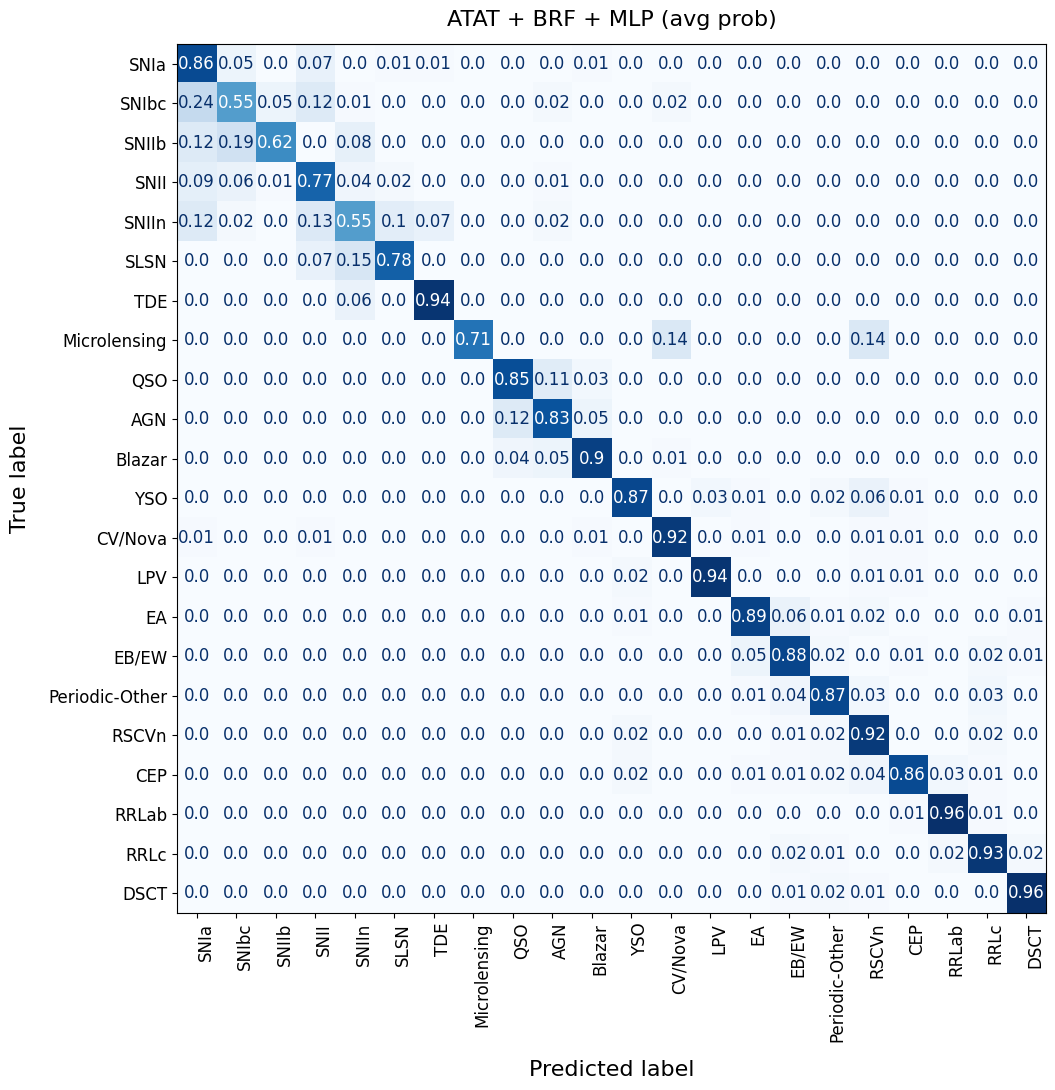

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('ATAT + BRF + MLP (avg prob)', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def get_metrics(dict_pred, y_test, list_eval_time, name_pred_key='list_y_prob'):
    f1_results_time = dict()
    bacc_results_time = dict()
    acc_results_time = dict()
    precision_results_time = dict()
    recall_results_time = dict()
    for eval_time in list_eval_time:
        y_pred = dict_pred[name_pred_key]['test_{}'.format(eval_time)]
        y_test = y_test

        f1_results_time[eval_time] = f1_score(y_test, y_pred, average='macro')
        bacc_results_time[eval_time] = balanced_accuracy_score(y_test, y_pred)
        acc_results_time[eval_time] = accuracy_score(y_test, y_pred)
        precision_results_time[eval_time] = precision_score(y_test, y_pred, average='macro')
        recall_results_time[eval_time] = recall_score(y_test, y_pred, average='macro')

    return f1_results_time

In [63]:
def plot_values_times(list_eval_time, models_f1_results_time, max_value, title=None, 
                      ylim_min=0, ylim_max=90, colors=None, f1_added=None):
    fs = 17

    plt.figure(figsize=(8, 7))

    for name_model, f1_results_time in models_f1_results_time.items():

        list_f1_mean_fold = []
        for eval_time in list_eval_time:
            list_f1_mean_fold.append(f1_results_time[eval_time]*100)

        print(list_f1_mean_fold)

        if name_model.find('MTA') != -1: 
            #plt.plot(np.log(list_eval_time)/np.log(2), list_f1_mean_fold, label=name_model, linestyle='dashed')#, color=colors[name_model])
            plt.scatter(list_eval_time, list_f1_mean_fold, label=name_model)
            #plt.fill_between(np.log(list_eval_time)/np.log(2), 
            #                list_f1_mean_fold + list_f1_std_fold, 
            #                list_f1_mean_fold - list_f1_std_fold, 
            #                alpha=0.4, color=colors[name_model])

        else:
            plt.plot(np.log(list_eval_time)/np.log(2), list_f1_mean_fold, label=name_model)#, color=colors[name_model])
            #plt.fill_between(np.log(list_eval_time)/np.log(2), 
            #                 list_f1_mean_fold + list_f1_std_fold, 
            #                 list_f1_mean_fold - list_f1_std_fold, 
            #                 alpha=0.5, color=colors[name_model])

            #plt.show()


    if f1_added is not None:
        plt.plot(np.log(list_eval_time)/np.log(2), f1_added['mean']*100, label='RF (Features + MD)', linestyle='-', color='#e41a1c')
    
        plt.fill_between(np.log(list_eval_time)/np.log(2), 
                        f1_added['mean']*100 + f1_added['std']*100, 
                        f1_added['mean']*100 - f1_added['std']*100, 
                        alpha=0.4, color='#e41a1c')
            
    plt.axhline(max_value*100, linestyle ="--", color='gray')

    # Add text above the axhline
    ax = plt.gca()  # Get the current Axes instance
    ax.text(0.5, max_value*100 + (ylim_max - ylim_min)*0.05, f'Max F1: {max_value*100:.2f}%', 
            transform=ax.get_yaxis_transform(), ha='center', fontsize=fs, color='gray')


    plt.yticks(fontsize=fs)
    plt.xticks(np.log(list_eval_time)/np.log(2), list_eval_time, fontsize=fs)

    plt.ylabel("F1-Score", fontsize=fs, labelpad=13)
    plt.xlabel("Evaluated time (days after first alert)", fontsize=fs, labelpad=13)
    plt.xscale('log') 
    plt.xticks([10**i for i in range(4)], [f'$10^{i}$' for i in range(4)])

    plt.ylim((ylim_min, ylim_max))
    #plt.legend(fontsize=fs) #, loc='lower right')

    ax.tick_params(axis='y', which='both', right=True, labelright=False) 

    #plt.savefig("all_curves_teval_a_last.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [64]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg', 'labels_used', 'ids_used', 'y_test_unique'])

In [65]:
dict_brf_predictions.keys()

dict_keys(['list_y_pred', 'list_y_pred_prob'])

In [66]:
y_test = dict_avg_pred_models['y_test']
len(y_test)

8346

In [67]:
dict_avg_pred_models

{'snids': ['aid_ZTF18adldhip',
  'aid_ZTF19aasbgeb',
  'aid_ZTF18aayfbqd',
  'aid_ZTF19ablyzbl',
  'aid_ZTF18actabfv',
  'aid_ZTF18aaztkvq',
  'aid_ZTF21aaphzsw',
  'aid_ZTF19aarhrcv',
  'aid_ZTF17aaajmxw',
  'aid_ZTF18acrvact',
  'aid_ZTF22aaahdyl',
  'aid_ZTF18aacebav',
  'aid_ZTF19abnqhwd',
  'aid_ZTF19abjgdow',
  'aid_ZTF18abklljv',
  'aid_ZTF18aalaphh',
  'aid_ZTF23aaaziou',
  'aid_ZTF17aacihzd',
  'aid_ZTF22abnmzar',
  'aid_ZTF17aaaoite',
  'aid_ZTF18abcurfb',
  'aid_ZTF18adbbyzu',
  'aid_ZTF18aaxpqts',
  'aid_ZTF18aacgwxk',
  'aid_ZTF18admcecv',
  'aid_ZTF18abukrnx',
  'aid_ZTF19aapuibt',
  'aid_ZTF18aawccep',
  'aid_ZTF21aahfpup',
  'aid_ZTF19aaoztzf',
  'aid_ZTF18aayijfg',
  'aid_ZTF18abgpcbj',
  'aid_ZTF18abwbiev',
  'aid_ZTF18actawil',
  'aid_ZTF20abyzomt',
  'aid_ZTF17aabxqbf',
  'aid_ZTF18abukymf',
  'aid_ZTF18abvbsoc',
  'aid_ZTF18actunfi',
  'aid_ZTF18aazfeau',
  'aid_ZTF22aaayewi',
  'aid_ZTF18aaxtcdl',
  'aid_ZTF18abtoxjw',
  'aid_ZTF18acdpxfb',
  'aid_ZTF18aabvmax',
 

In [68]:
list_eval_time = [16, 32, 64, 128, 256, 512, 1024, 2048]

In [69]:
dict_avg_pred_models['list_y_pred_avg']['test_1024'].shape

(8346,)

In [70]:
dict_brf_predictions['list_y_pred']['test_1024'].shape

(8346,)

In [71]:
len(y_test)

8346

In [72]:
dict_mlp_predictions['list_y_pred']['test_1024'].shape

(8346,)

In [73]:
dict_atat_predictions['list_y_pred']['test_1024'].shape

(8346,)

In [74]:
f1_models = get_metrics(dict_avg_pred_models, y_test, list_eval_time, name_pred_key='list_y_pred_avg')
f1_brf = get_metrics(dict_brf_predictions, y_test, list_eval_time, name_pred_key='list_y_pred')
f1_mlp = get_metrics(dict_mlp_predictions, y_test, list_eval_time, name_pred_key='list_y_pred')
f1_atat = get_metrics(dict_atat_predictions, y_test, list_eval_time, name_pred_key='list_y_pred')

In [75]:
f1_atat

{16: 0.5650018117477226,
 32: 0.604001986524528,
 64: 0.656693438723615,
 128: 0.695708645657004,
 256: 0.6995096213808033,
 512: 0.7352424528116114,
 1024: 0.735713078796553,
 2048: 0.7428290983207517}

In [76]:
models_f1_results_time = {
    'ATAT (LC + MD + FEAT + MTA)': f1_atat,
    #'MLP': f1_mlp,
    #'BRF': f1_brf,
    #'ATAT + BRF + MLP (avg prob)': f1_models,
}

colors = {
    'ATAT (LC + MD + FEAT + MTA)': '#ff7f00',
    #'MLP': '#984ea3',
    #'BRF': '#17BECF',
    #'ATAT + BRF + MLP (avg prob)': '#4daf4a',
}

In [77]:
models_f1_results_time

{'ATAT (LC + MD + FEAT + MTA)': {16: 0.5650018117477226,
  32: 0.604001986524528,
  64: 0.656693438723615,
  128: 0.695708645657004,
  256: 0.6995096213808033,
  512: 0.7352424528116114,
  1024: 0.735713078796553,
  2048: 0.7428290983207517}}

In [78]:
max_value = max(max(model.values()) for model in models_f1_results_time.values())
print(max_value)

0.7428290983207517


[56.50018117477226, 60.400198652452794, 65.6693438723615, 69.57086456570039, 69.95096213808033, 73.52424528116114, 73.57130787965531, 74.28290983207518]


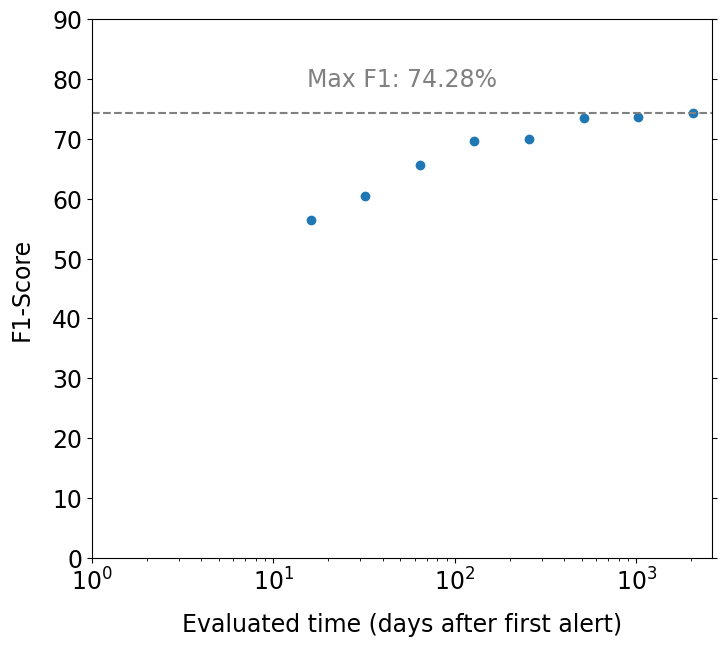

In [79]:
plot_values_times(list_eval_time, models_f1_results_time, max_value)

In [60]:
dict_atat_predictions.keys()

dict_keys(['list_y_pred', 'list_y_pred_prob'])

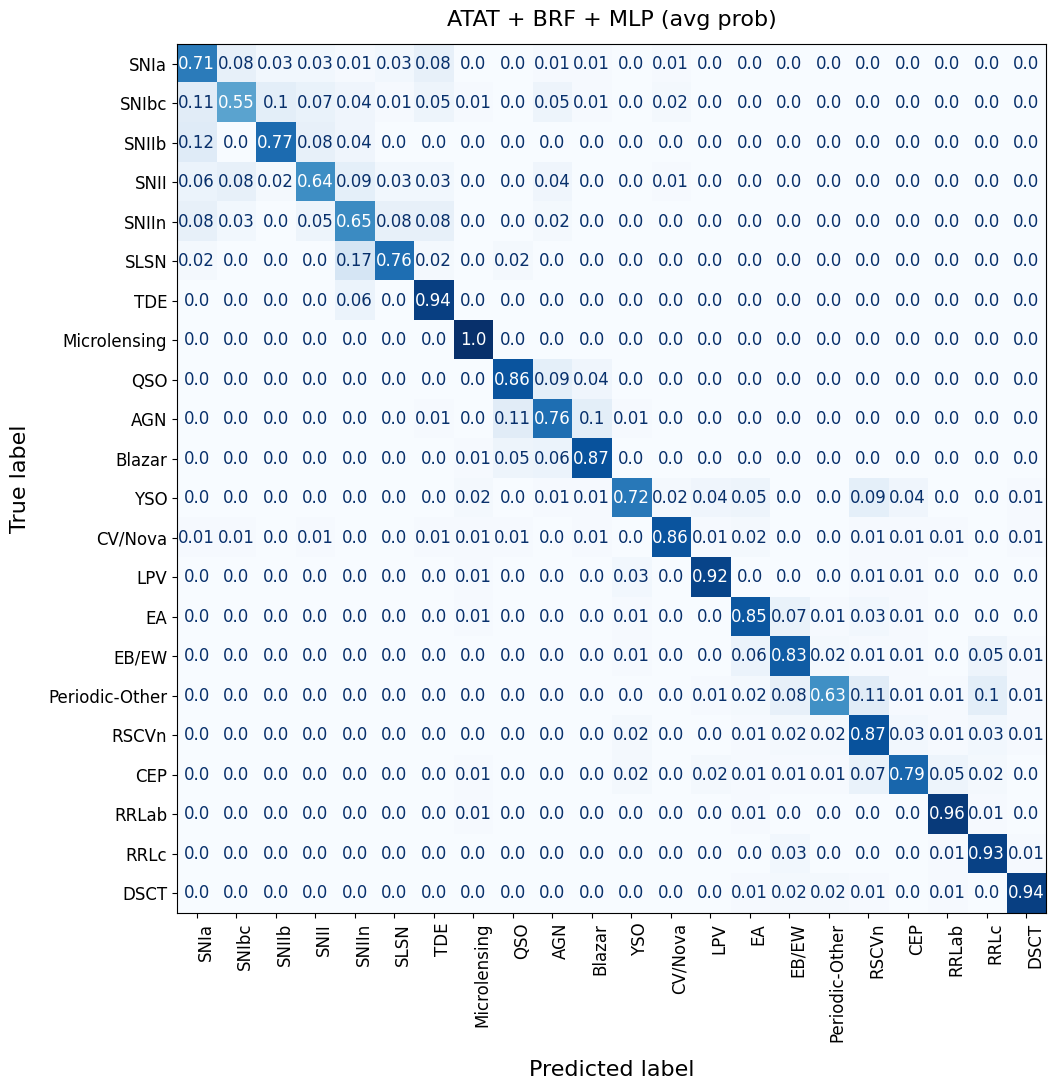

In [61]:
y_test_label = dict_avg_pred_models['y_test']
y_pred_label = dict_brf_predictions['list_y_pred']['test_2048']

y_test_label = [mapping_classes_inverted[x] for x in y_test_label]
y_pred_label = [mapping_classes_inverted[x] for x in y_pred_label]

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('ATAT + BRF + MLP (avg prob)', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

## ATAT (LC + MD + Features + MTA) 

In [62]:
with open('final_dataset/dict_classes.json') as f:
   dict_classes = json.load(f)

print(dict_classes)
dict_classes = {v: k for k, v in dict_classes.items()}

#path_exp = 'results_paper/lc/Exp_cfg_-arch=lc_mtime'
path_exp = 'results_paper/lc_tab/Exp_cfg_-arch=lc_header_feat_mtime'
folds = [0, 1, 2, 3, 4]

list_pred_folds = get_y_test_pred_folds(path_exp, dict_classes, folds)

FileNotFoundError: [Errno 2] No such file or directory: 'final_dataset/dict_classes.json'

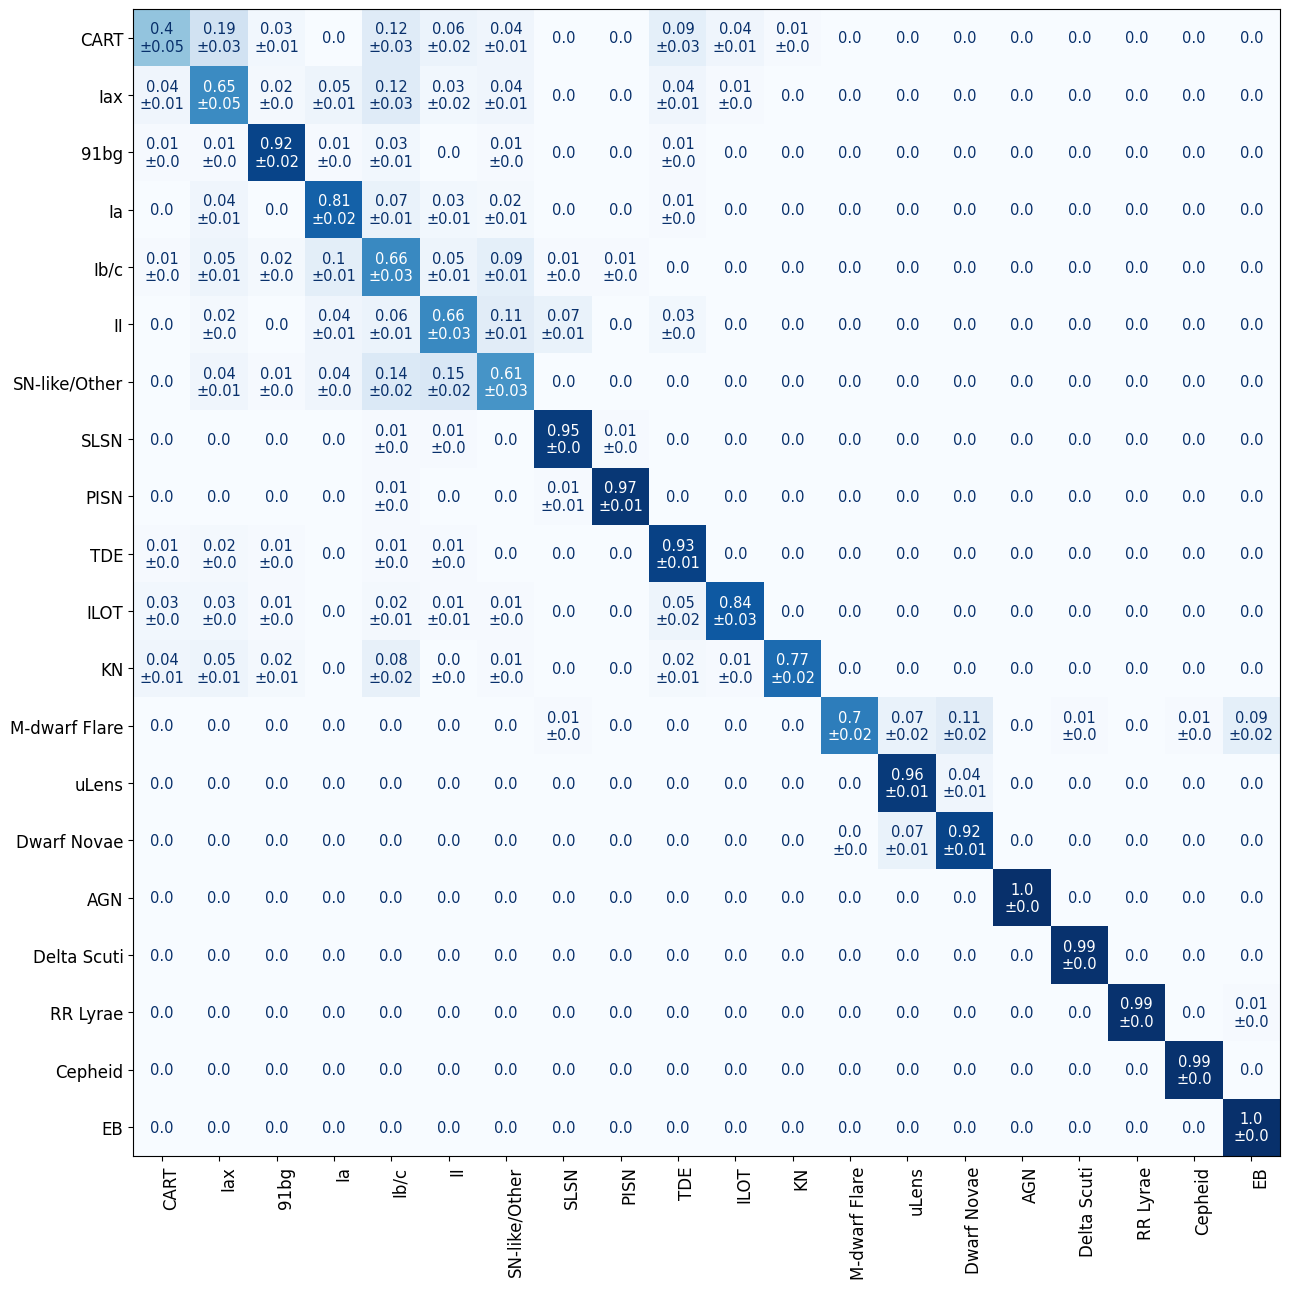

In [ ]:
# Suponiendo que tienes y_test_label1, y_pred_label1, y_test_label2, y_pred_label2, etc.
matrices = []
for y_test, y_pred in list_pred_folds:
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_lc_md_feat = np.mean(matrices, axis=0)
std_matrix_lc_md_feat = np.std(matrices, axis=0)

get_confusion_matrix(mean_matrix_lc_md_feat, std_matrix_lc_md_feat, order_classes)

## ATAT (LC + MD + MTA) 

In [ ]:
#path_exp = 'results_paper/lc/Exp_cfg_-arch=lc_mtime'
path_exp = 'results_paper/lc_tab/Exp_cfg_-arch=lc_header_mtime'
folds = [0, 1, 2, 3, 4]

list_pred_folds = get_y_test_pred_folds(path_exp, dict_classes, folds)

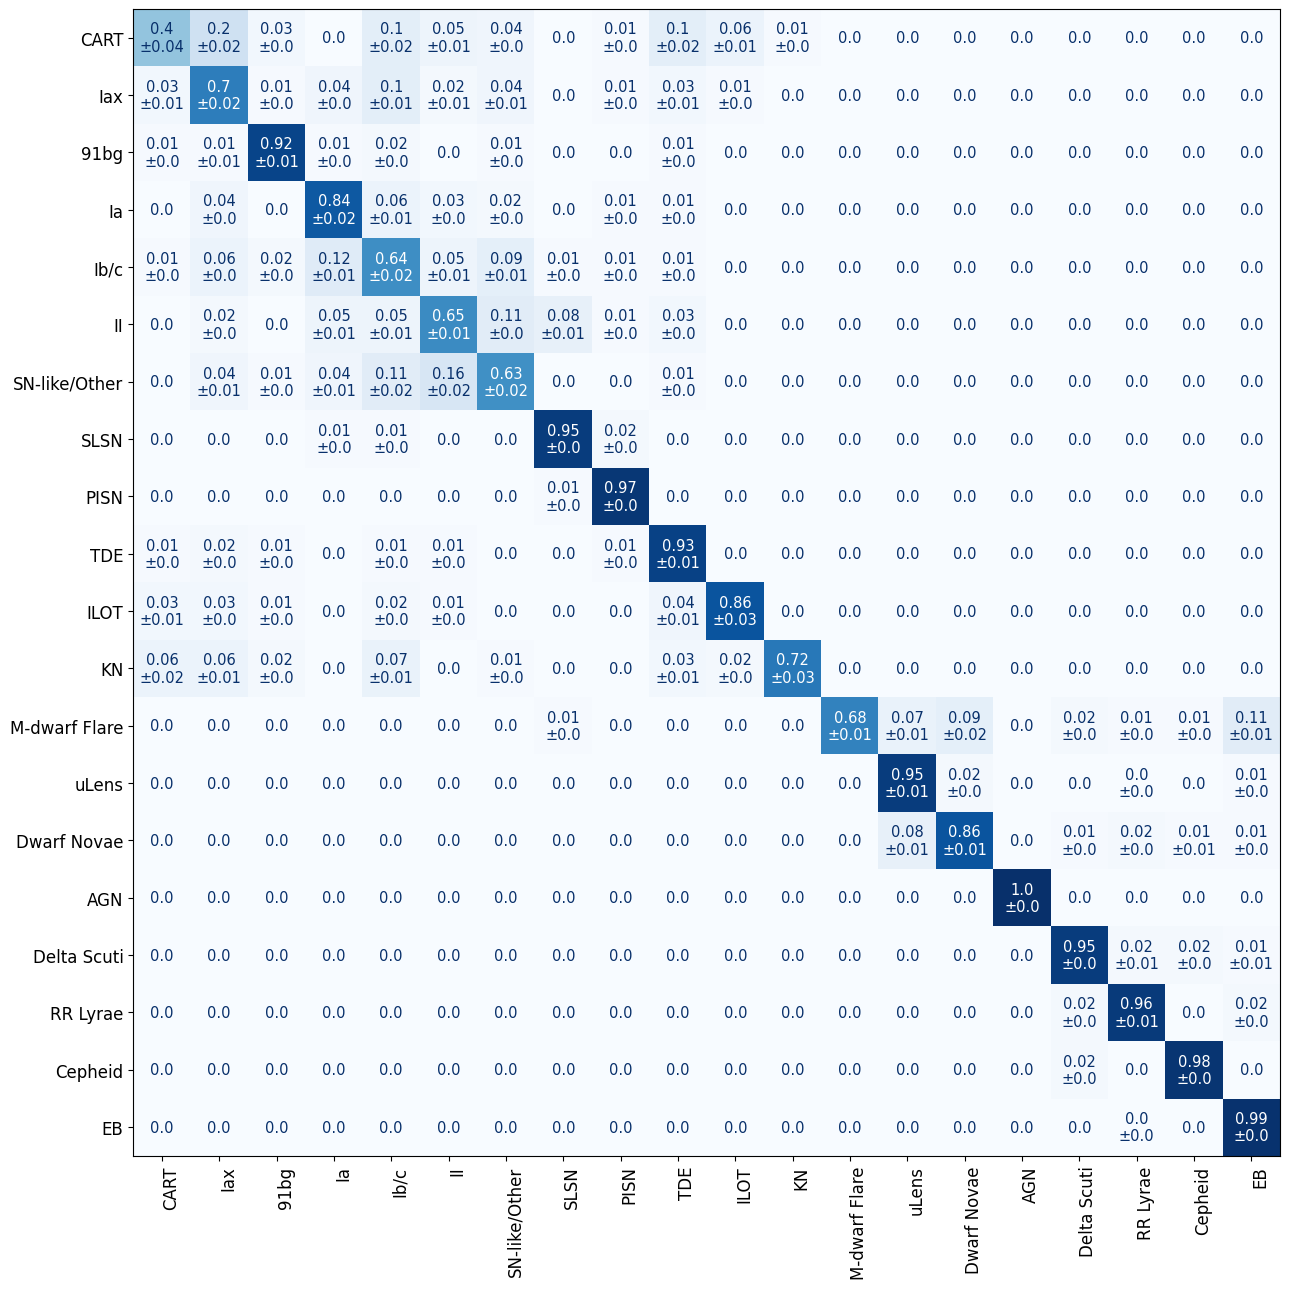

In [ ]:
# Suponiendo que tienes y_test_label1, y_pred_label1, y_test_label2, y_pred_label2, etc.
matrices = []
for y_test, y_pred in list_pred_folds:
    cm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_lc_md = np.mean(matrices, axis=0)
std_matrix_lc_md = np.std(matrices, axis=0)

get_confusion_matrix(mean_matrix_lc_md, std_matrix_lc_md, order_classes)

## Random Forest

In [ ]:
import pandas as pd

path_root = 'results_rf_paper/2048_days'

In [ ]:
test_proba_model = []
num_fold = 5

for i_fold in range(num_fold):
    test_proba_model.append(pd.read_parquet('./{}/test_predictions_proba_model_{}.parquet'.format(path_root, i_fold)))

    for idx_row in range(test_proba_model[i_fold].shape[0]):
        idx_col = test_proba_model[i_fold].iloc[idx_row].argmax()
        test_proba_model[i_fold].iloc[idx_row][idx_col] = 1

    test_proba_model[i_fold][test_proba_model[i_fold] != 1] = 0
    test_proba_model[i_fold] = test_proba_model[i_fold][order_classes]

display(test_proba_model[0].head())
display(test_proba_model[1].head())
print(test_proba_model[0].shape)

CART  Iax  91bg   Ia  ...  Delta Scuti  RR Lyrae  Cepheid   EB
SNID                                 ...                                     
63769469_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
66380842_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
64815643_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
52486614_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
34971786_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0

[5 rows x 20 columns]

CART  Iax  91bg   Ia  ...  Delta Scuti  RR Lyrae  Cepheid   EB
SNID                                 ...                                     
63769469_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
66380842_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
64815643_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
52486614_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
34971786_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0

[5 rows x 20 columns]

(20000, 20)


In [ ]:
test_set = pd.read_parquet('./data_partition_paper/partitions.parquet')
test_set = test_set[test_set.partition == 'test'].drop(['partition'], axis=1)
test_set['SNID'] = test_set['SNID'].apply(lambda row: row+'_2048')
test_set = test_set.set_index('SNID')
test_set = pd.get_dummies(test_set.label, dtype=float)
test_set = test_set[order_classes]
test_set

CART  Iax  91bg   Ia  ...  Delta Scuti  RR Lyrae  Cepheid   EB
SNID                                 ...                                     
63769469_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
66380842_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
64815643_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
52486614_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
34971786_2048   0.0  0.0   1.0  0.0  ...          0.0       0.0      0.0  0.0
...             ...  ...   ...  ...  ...          ...       ...      ...  ...
34694580_2048   0.0  0.0   0.0  0.0  ...          0.0       0.0      0.0  0.0
42840389_2048   0.0  0.0   0.0  0.0  ...          0.0       0.0      0.0  0.0
28545440_2048   0.0  0.0   0.0  0.0  ...          0.0       0.0      0.0  0.0
19549596_2048   0.0  0.0   0.0  0.0  ...          0.0       0.0      0.0  0.0
52428273_2048   0.0  0.0   0.0  0.0  ...          0.0       0.0      0.0  0.0

[20000 rows x 20 columns]

In [ ]:
list_pred_folds = []
for i_fold in folds:
    y_test = np.argmax(test_set.reindex(test_proba_model[i_fold].index).values, axis=1)
    y_pred = np.argmax(test_proba_model[i_fold].values, axis=1)

    y_test_label = [dict_classes[x] for x in y_test]
    y_pred_label = [dict_classes[x] for x in y_pred]

    list_pred_folds.append((y_test_label, y_pred_label))
    

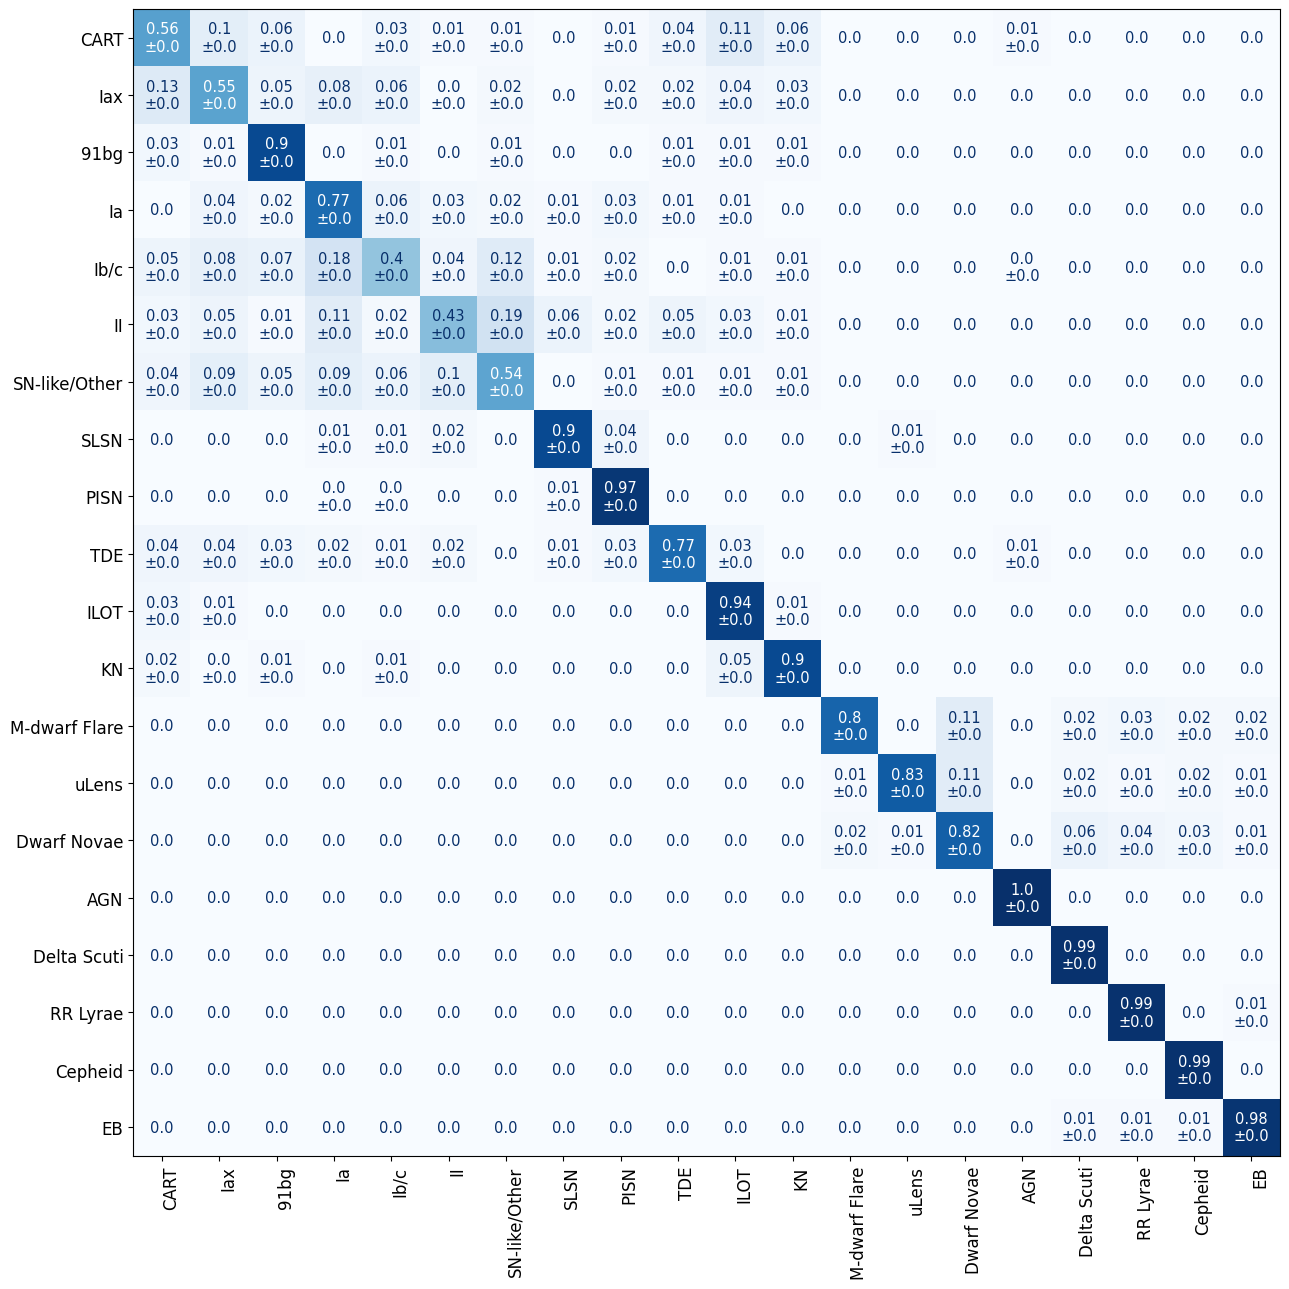

In [ ]:
matrices = []
for y_test, y_pred in list_pred_folds:
    cm = confusion_matrix(np.argmax(test_set.reindex(test_proba_model[i_fold].index).values, axis=1), 
                          np.argmax(test_proba_model[i_fold].values, axis=1), 
                          normalize='true')
    #cm = confusion_matrix(test_set.reindex(test_proba_model[i_fold].index).values, test_proba_model[i_fold].values, normalize='pred')
    matrices.append(cm)

# Calculando la media y la desviación estándar
mean_matrix_rf = np.mean(matrices, axis=0)
std_matrix_rf = np.std(matrices, axis=0)

get_confusion_matrix(mean_matrix_rf, std_matrix_rf, order_classes)

## Joint plot

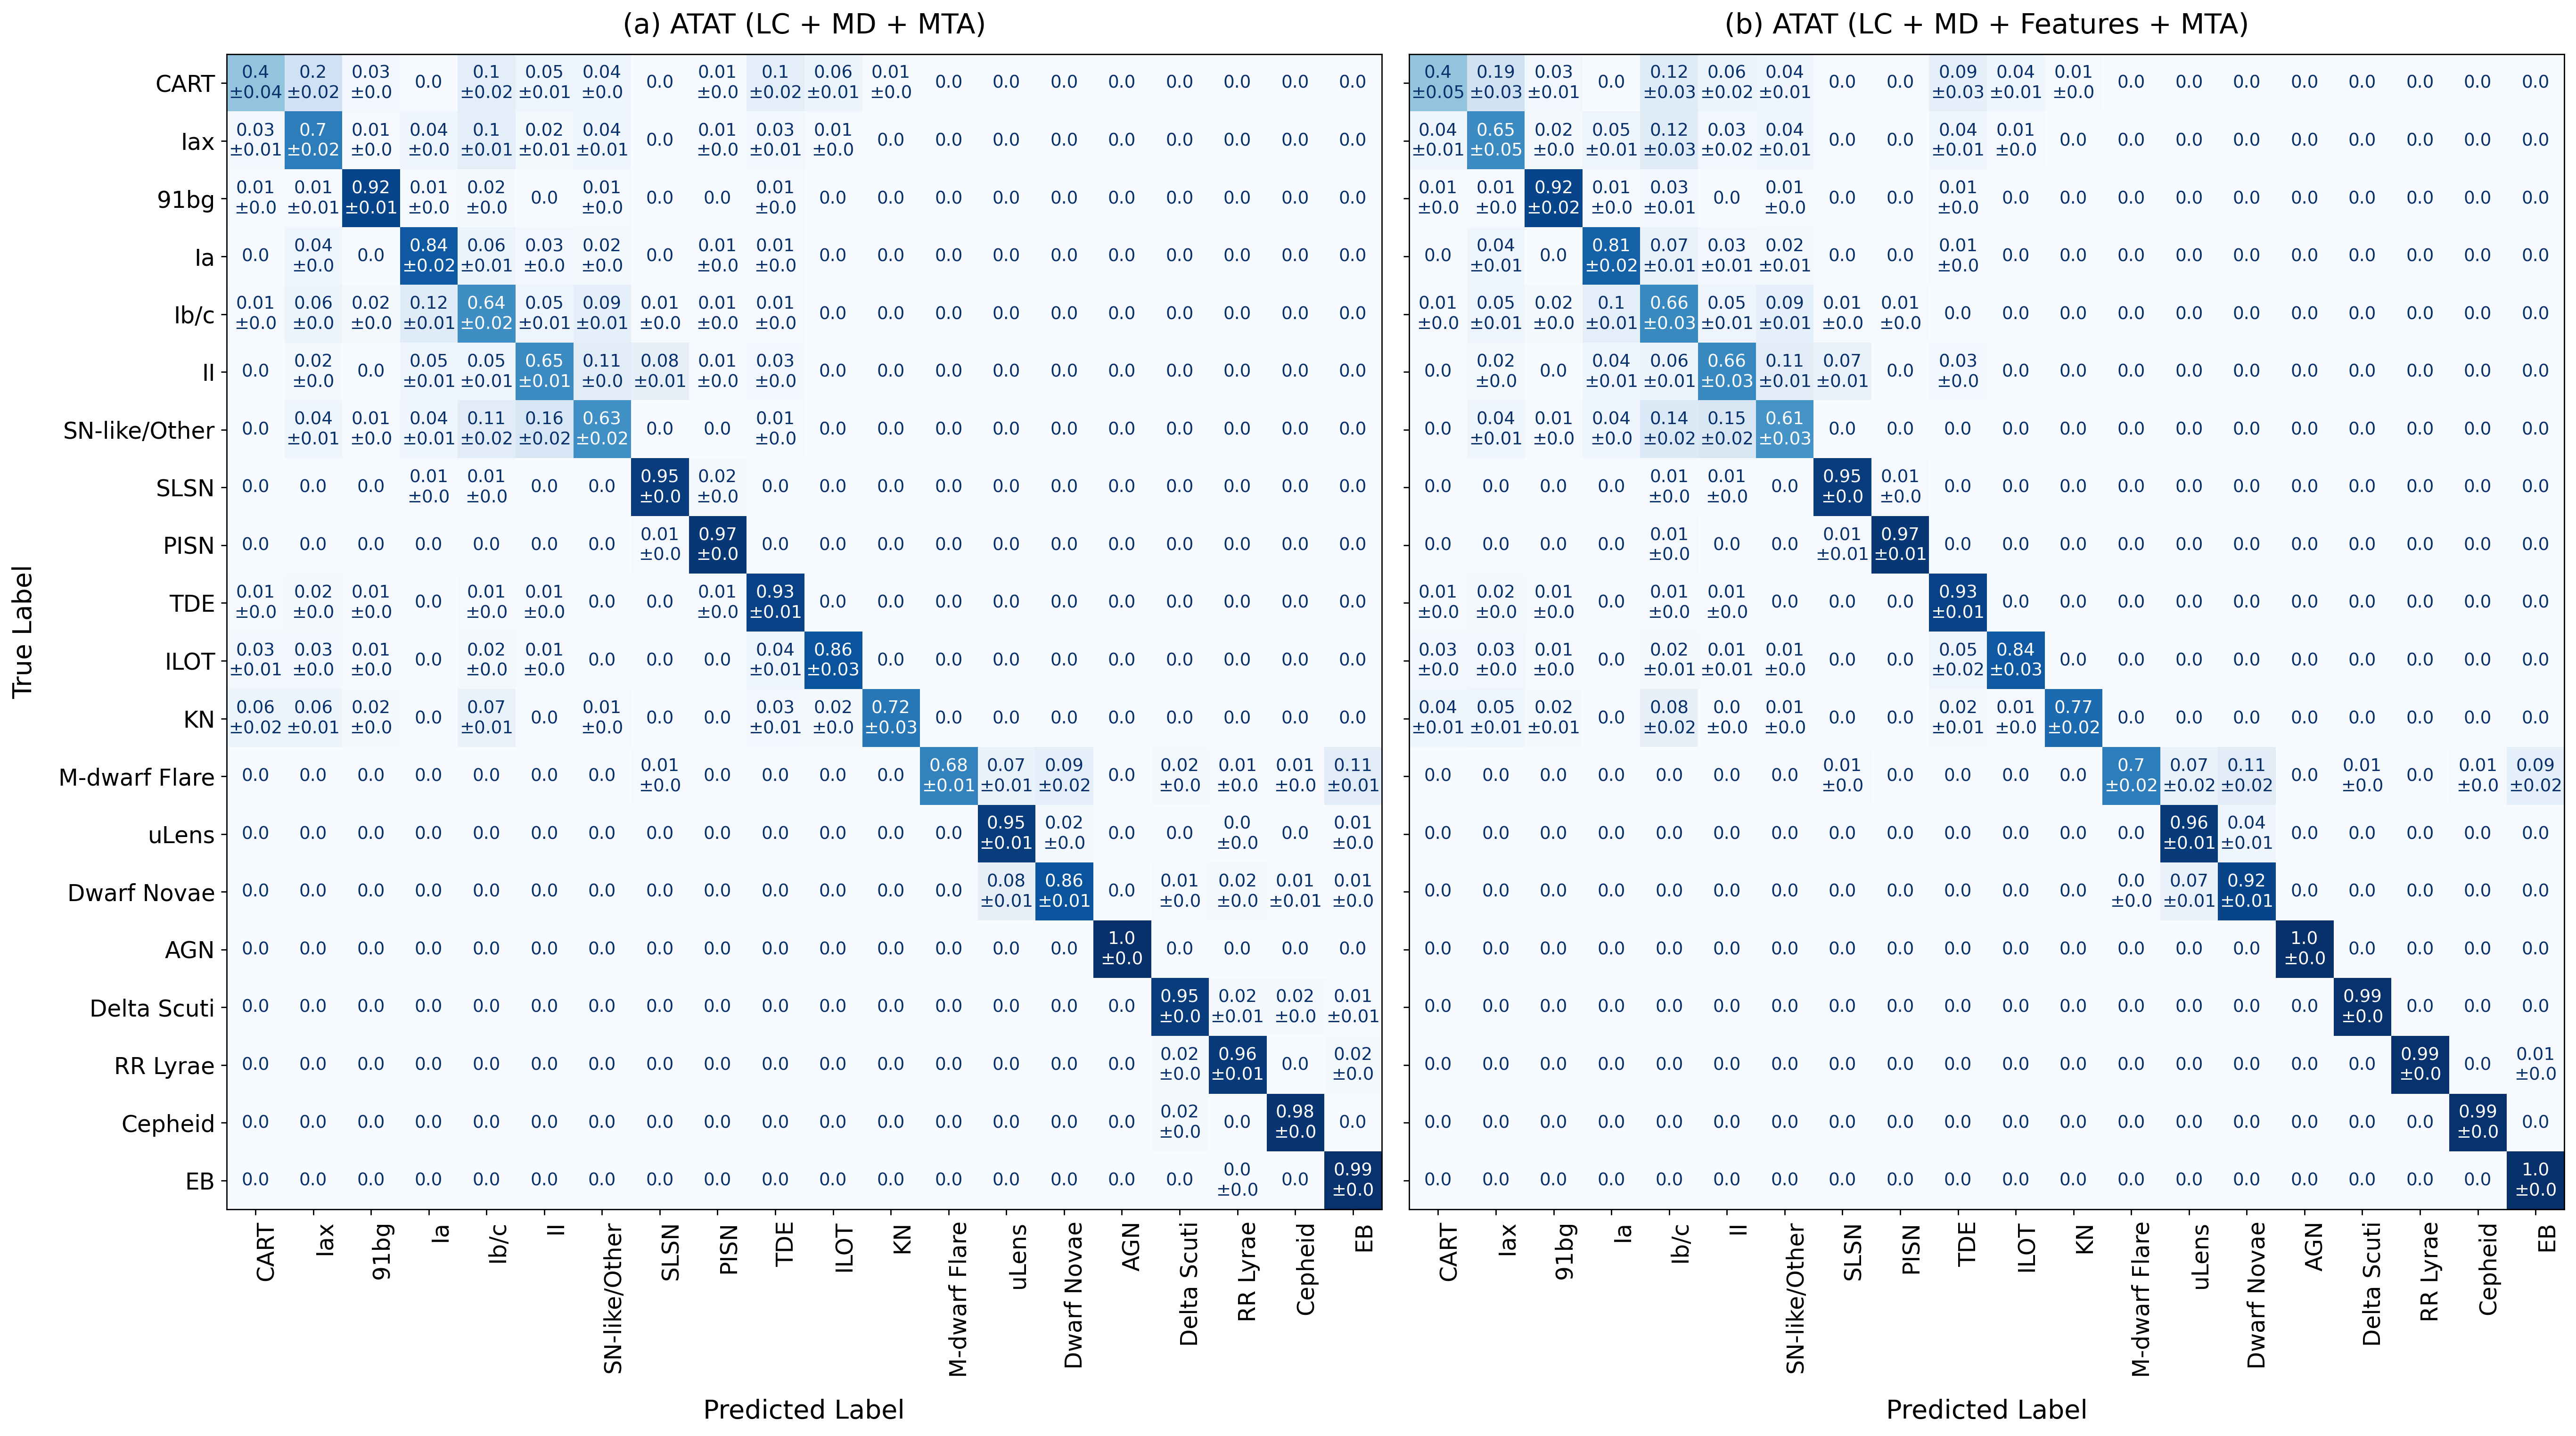

In [ ]:
# Graficando la matriz media
cmap = plt.cm.Blues
#fig, ax = plt.subplots(figsize=(13, 13)) #, dpi=110)
fig, axes = plt.subplots(1, 2, figsize=(22, 22), sharey=True, dpi=250)

titles = ['(a) ATAT (LC + MD + MTA)', '(b) ATAT (LC + MD + Features + MTA)']
mean_matrices_col = [mean_matrix_lc_md, mean_matrix_lc_md_feat]
std_matrices_col = [std_matrix_lc_md, std_matrix_lc_md_feat]

for cont, (ax, mean_matrix, std_matrix) in enumerate(zip(axes, mean_matrices_col, std_matrices_col)):
    im = ax.imshow(np.around(mean_matrix, decimals=2), interpolation='nearest', cmap=cmap)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(mean_matrix.shape[0]):
        for j in range(mean_matrix.shape[1]):
            if mean_matrix[i, j] >= 0.005:
                #print(mean_matrix[i, j])
                text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)
            else:
                text = f'{np.around(mean_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrix[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    ax.set_title(titles[cont], fontsize=17, pad=13)
    ax.set_xlabel('Predicted Label', fontsize=16)

    if cont == 0:
        ax.set_ylabel('True Label', fontsize=16)

plt.tight_layout()
#os.makedirs('images', exist_ok=True)
#plt.savefig("./images/cm_ATAT.pdf", format="pdf", bbox_inches="tight")
plt.show()

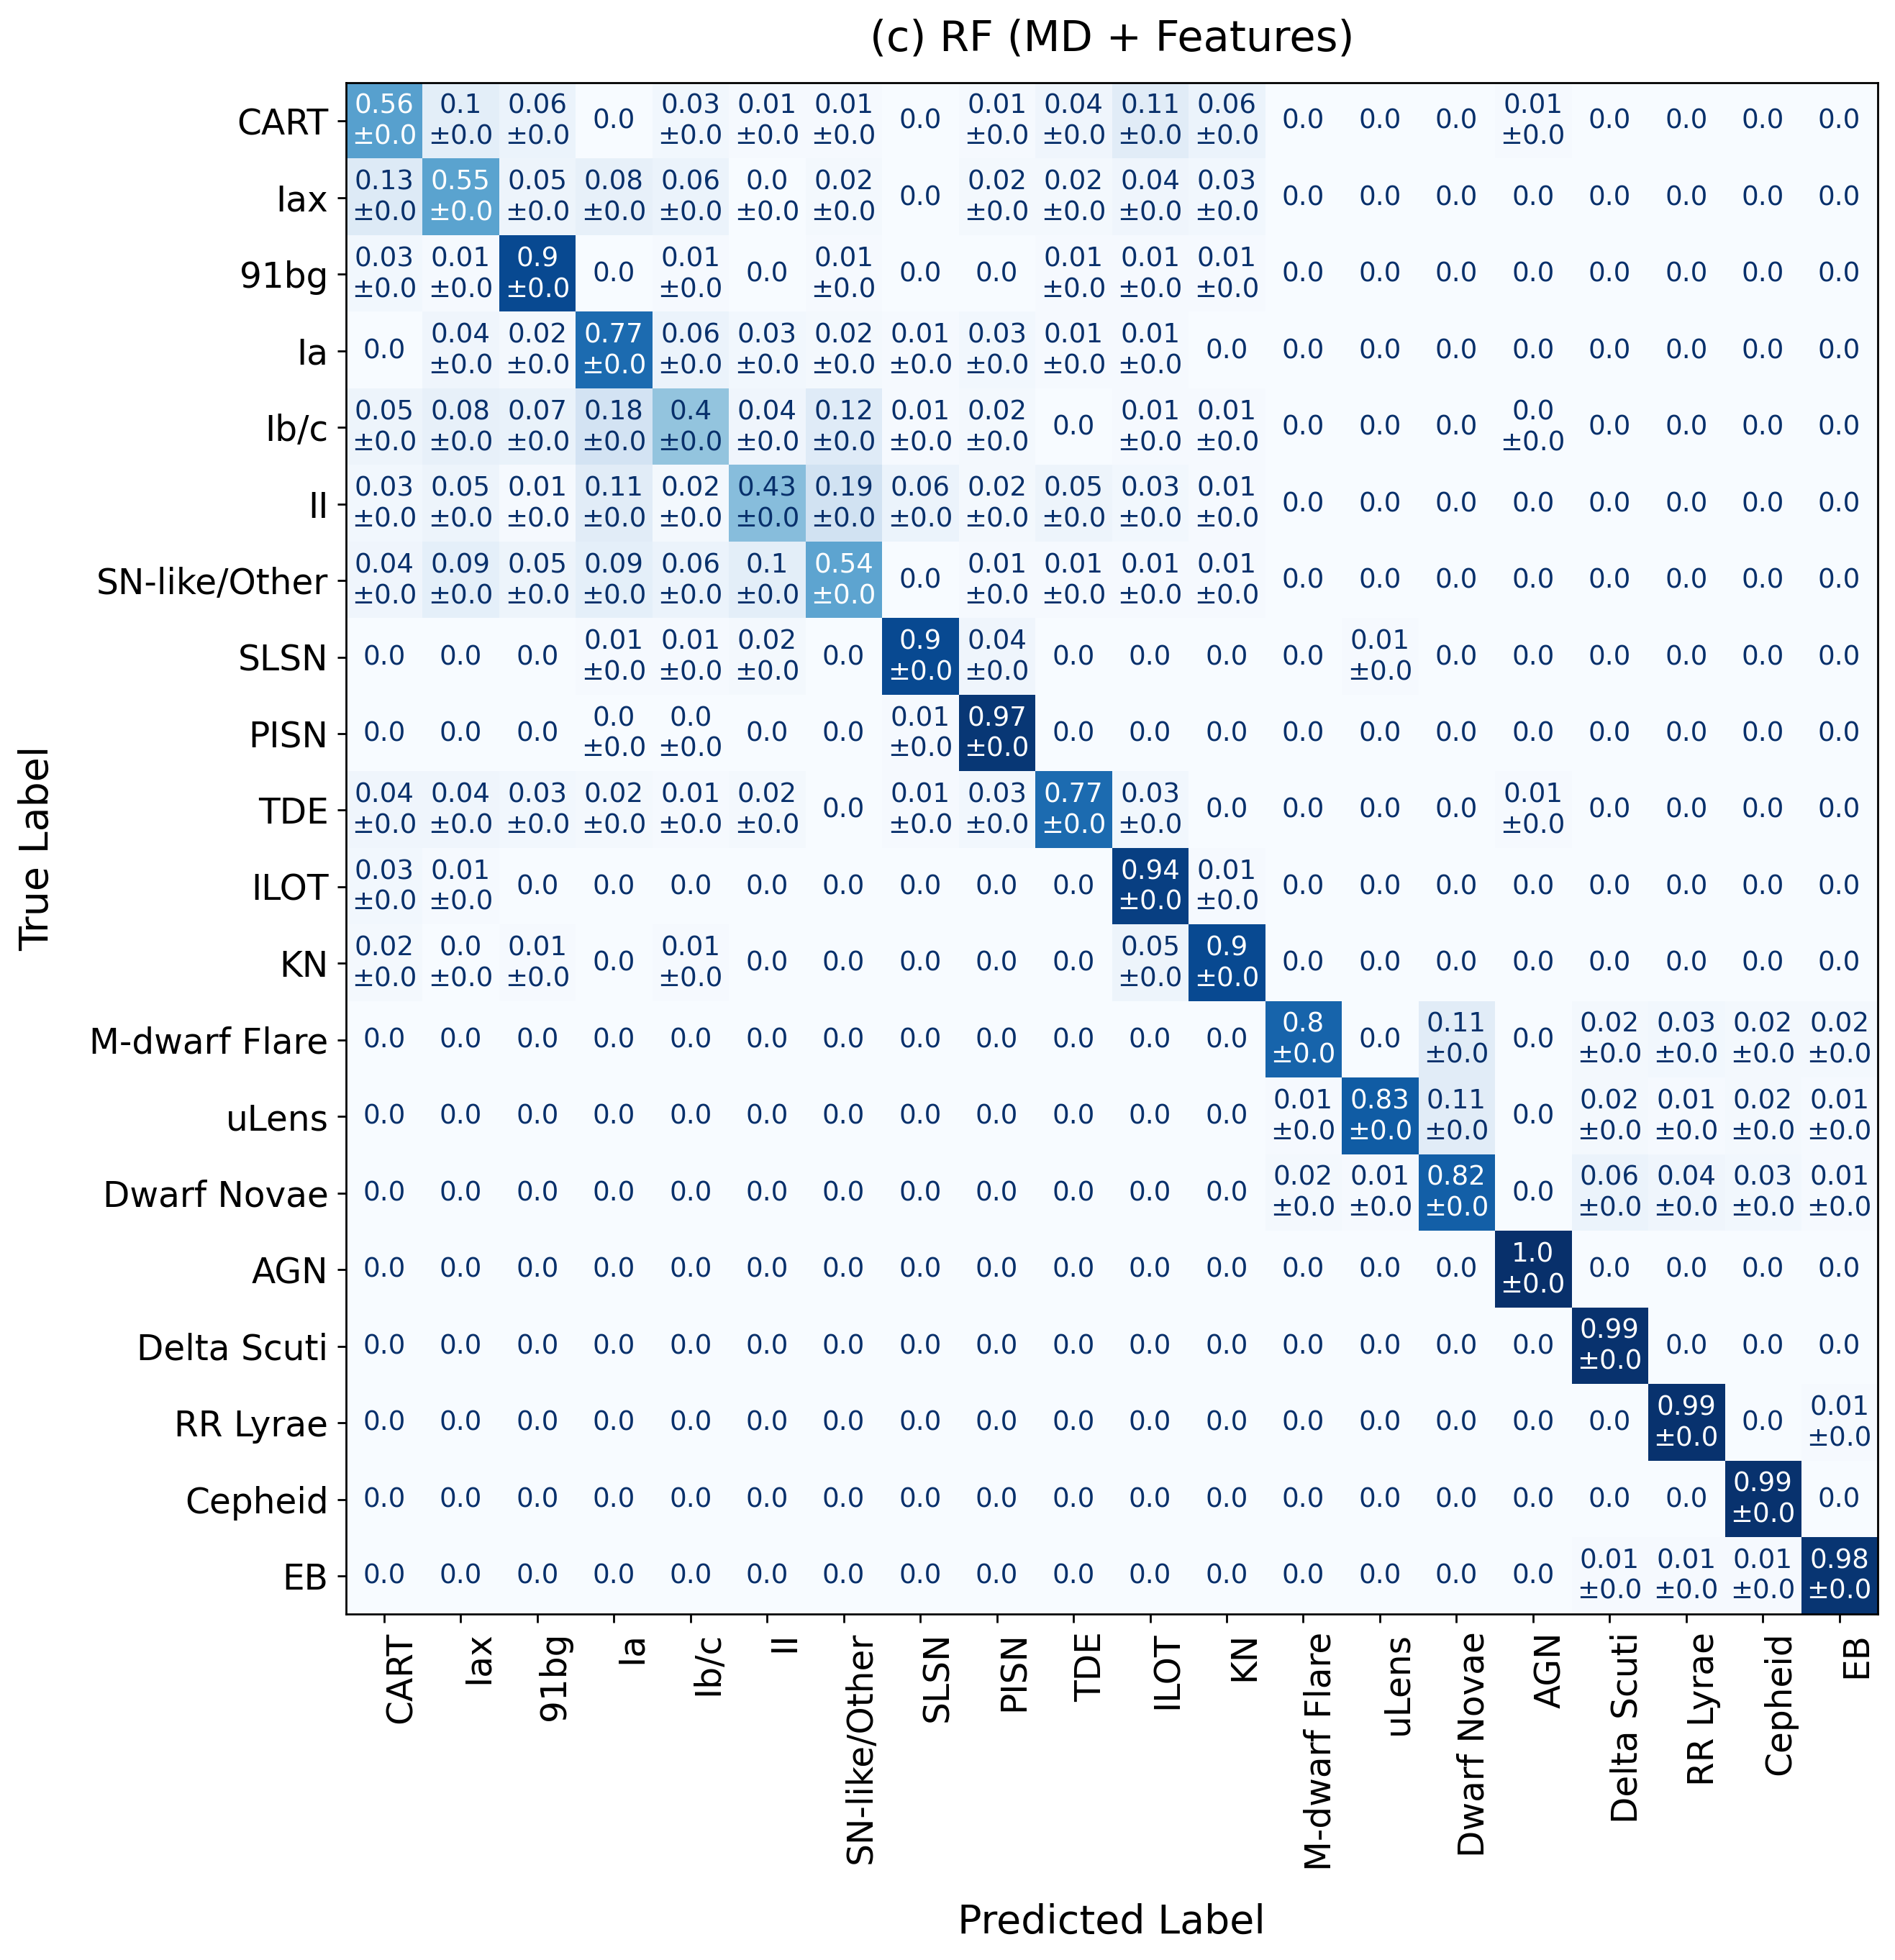

In [ ]:
title = '(c) RF (MD + Features)'

# Graficando la matriz media
cmap = plt.cm.Blues
#fig, ax = plt.subplots(figsize=(13, 13)) #, dpi=110)
fig, ax = plt.subplots(1, 1, figsize=(11, 11), sharey=True, dpi=250)

im = ax.imshow(np.around(mean_matrix_rf, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(mean_matrix_rf.shape[0]):
    for j in range(mean_matrix_rf.shape[1]):
        if mean_matrix_rf[i, j] >= 0.005:
            #print(mean_matrix_rf[i, j])
            text = f'{np.around(mean_matrix_rf[i, j], decimals=2)}\n±{np.around(std_matrix_rf[i, j], decimals=2)}'
            color = "white" if mean_matrix_rf[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)
        else:
            text = f'{np.around(mean_matrix_rf[i, j], decimals=2)}'
            color = "white" if mean_matrix_rf[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10.7)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

ax.set_title(title, fontsize=17, pad=13)
ax.set_xlabel('Predicted Label', fontsize=16)
ax.set_ylabel('True Label', fontsize=16)

plt.tight_layout()
#os.makedirs('images', exist_ok=True)
#plt.savefig("./images/cm_rf.pdf", format="pdf", bbox_inches="tight")
plt.show()